Proportion Of Different Smoking Categories Among Stroke Population

In [41]:
import pandas as pd
import numpy as np
import pickle

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

import plotly
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns


# import warnings
import warnings
# filter warnings
warnings.filterwarnings('ignore')
# Input data files are available in the read-only "../input/" directory
import os

In [42]:
origin_data = pd.read_csv(r'..\Dataset\strokeDataset.csv')
#(r'..\Dataset\strokeDataset.csv')
data = origin_data.copy()
data_v=origin_data.copy()


### Data Exploration
take a first look at the data and try to understand the data

In [43]:
data

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


there are 5110 rows and 12 columns in the dataset.<br><br>
next we will check the data type of each column 

In [44]:
data.info()
data.dtypes.value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


object     5
int64      4
float64    3
Name: count, dtype: int64

It can be observed that <br>
- 5 object type columns    (gender, ever_married, work_type, Residence_type, smoking_status)
- 4 int type columns  (id, stroke, hypertension, heart_disease)
- 3 float type columns      (age, avg_glucose_level, bmi)

<br>
Let's look at our target Column 'stroke' and see how many people have had a stroke

In [45]:


data_v['stroke'] = data_v['stroke'].replace({1: 'Yes', 0: 'No'})
stroke_counts = data_v['stroke'].value_counts().reset_index()
fig = px.pie(stroke_counts, names='stroke', values='count',
             title='Distribution of Stroke Status', width=400, height=400)

fig.show()

Observation :<br>
- 95% of the people in the dataset have not had a stroke and only 5% of the people have had a stroke
- we can see this is an imbalanced dataset
- so we will have to balance the dataset before training the model

<br>
Take a look at the distribution of the numerical columns(avg_glucose_level, bmi , age not considered )

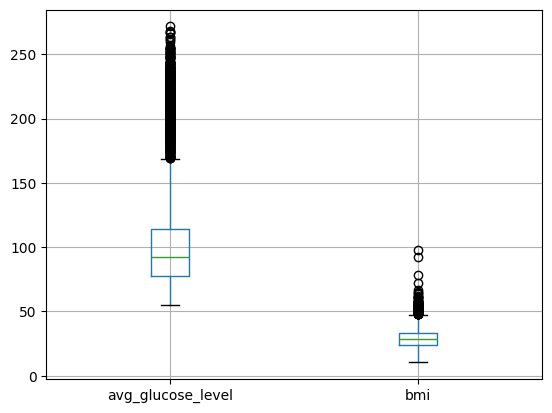

In [46]:
boxplot = data_v.boxplot(column=['avg_glucose_level', 'bmi'])

Observation :<br>
- we can see that both bmi and avg_glucose_level have a good number of outliers
- but since our target audience(Amercian) have a high obesity rate, we will not remove the outliers
- so these can be considered as valid data points
- Models that deal well with outliers should be used(eg. logistic regression, decision tree)

Checking skewness of the numerical columns

array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'avg_glucose_level'}>],
       [<Axes: title={'center': 'bmi'}>, <Axes: >]], dtype=object)

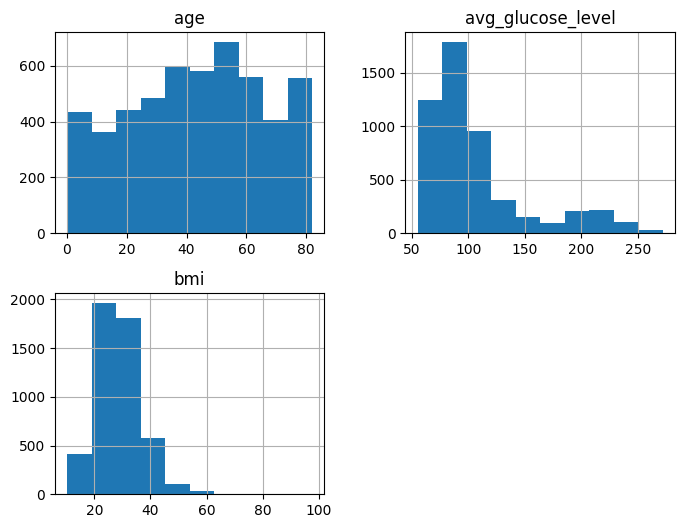

In [72]:

numerical_features = ['age', 'avg_glucose_level', 'bmi']
data_v[numerical_features].hist(figsize=(8,6))


Observations :<br>
- different columns have different levels of  skewness

In [47]:
#putting attributes in a list to check their correlations with each other
# converting yes and no to 1 and 0 in stroke 

cont_cols = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'stroke']
data_v['stroke'] = data_v['stroke'].replace({'Yes': 1, 'No': 0})

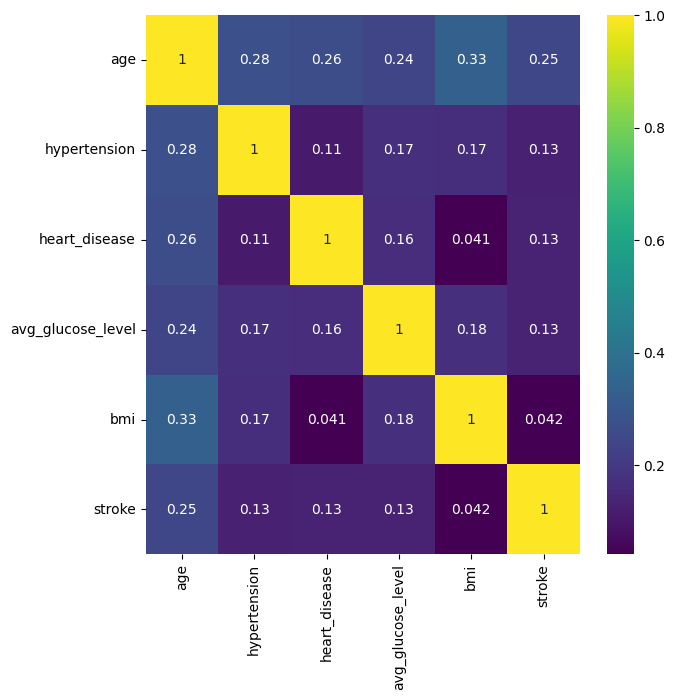

In [49]:
cr = data_v[cont_cols].corr()
plt.figure(figsize = (7,7))
sns.heatmap(cr,cmap="viridis", annot = True)
plt.show()

- no strong correlation between the numerical columns
- strong correlation is between age and stroke
- weakest correlation is between age and hypertension, heart_disease(which is questionable)

Age has the highest correlation with stroke, so let's take a look at the age distribution of the people who have had a stroke

In [70]:
fig = px.histogram(data_v, x='age', color='stroke', marginal='box', nbins=47, title='Age Distribution')
fig.show()

Observations :<br>
- we can see that the people who have had a stroke are mostly above 50 years of age
- so age is a good indicator of stroke


Categorical data distribution in the dataset

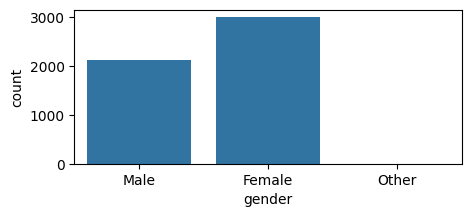

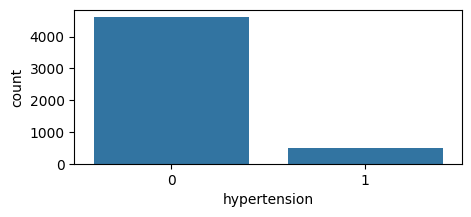

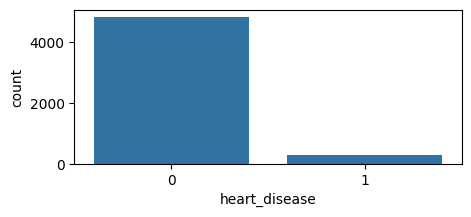

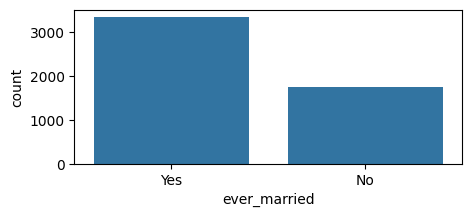

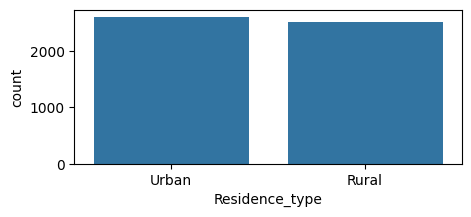

In [50]:

#putting categorical data ina array
data_cat=data_v[['gender', 'hypertension', 'heart_disease', 'ever_married', 'Residence_type']]

for col in data_cat.columns:
    plt.figure(figsize=(5,2))
    sns.countplot(x=col, data=data_cat)
    plt.show()


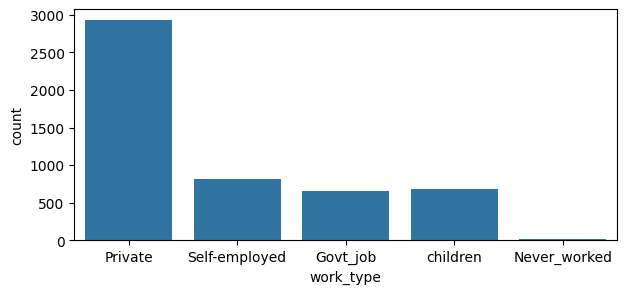

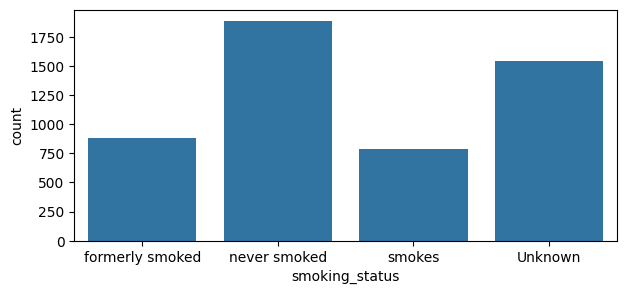

In [51]:
data_cat2=data_v[['work_type','smoking_status']]

for col2 in data_cat2.columns:
    plt.figure(figsize=(7,3))
    sns.countplot(x=col2, data=data_cat2)
    plt.show()

### Data Preprocessing

In [52]:
#Dropping the id column that has no correlation with the target variable
data.drop(['id'], axis=1, inplace=True)

checking for missing values

In [53]:
check = data_v.isnull().sum()
check

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

 fill null values in bmi column with the mean of the bmi column

In [54]:
data['bmi'].fillna(data['bmi'].mean(), inplace=True)

Check for duplicate values 

In [55]:
duplicate = data.duplicated()
duplicate.sum()

0

No duplicate values found


In [56]:
data.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.893237,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1


Converting some categorical columns into numerical columns

In [57]:
# Convert Marrital Status, Residence and Gender into 0's and 1's
data['gender']=data['gender'].apply(lambda x : 1 if x=='Male' else 0) 
data["Residence_type"] = data["Residence_type"].apply(lambda x: 1 if x=="Urban" else 0)
data["ever_married"] = data["ever_married"].apply(lambda x: 1 if x=="Yes" else 0)


- removing 'unkown' from smoking status 
- onehot encoding smoking_status and work_type

In [58]:
# Removing the observations that have smoking type unknown. 
data=data[data['smoking_status']!='Unknown']

# One Hot encoding smoking_status, work_type
data_dummies = data[['smoking_status','work_type']]
data_dummies=pd.get_dummies(data_dummies)
data.drop(columns=['smoking_status','work_type'],inplace=True)

splitting the target column from the dataset

In [59]:
data_stroke=data['stroke']
data.drop(columns=['stroke'],inplace=True)
data=data.merge(data_dummies,left_index=True, right_index=True,how='left')


splitting the dataset into train and test set

In [60]:
X_train, X_test, Y_train, Y_test=train_test_split(data,data_stroke,test_size=0.2,random_state=10)

balancing the dataset using SMOTE

In [61]:
sm = SMOTE(random_state=4)
X_train, Y_train = sm.fit_resample(X_train, Y_train.ravel())

#### Model building

In [62]:
class_models = {
    
    "Decision Tree": DecisionTreeClassifier(),
    "Logistic Regression": LogisticRegression(),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(),
    "Naive Bayes": GaussianNB(var_smoothing=1e-09,),
}

class_scores = {}

for class_name, model in class_models.items():
    model.fit(X_train, Y_train)


    #get the score of each model 
    class_scores[class_name] = model.score(X_test, Y_test)


    #print model and its score
    print(f"Model Name :  {class_name}")
    print(f"Model Score :  {class_scores[class_name]}")
    print("")

Model Name :  Decision Tree
Model Score :  0.8823529411764706

Model Name :  Logistic Regression
Model Score :  0.896358543417367

Model Name :  KNN
Model Score :  0.7829131652661064



Model Name :  SVM
Model Score :  0.6904761904761905

Model Name :  Naive Bayes
Model Score :  0.19327731092436976



- Logistic Regression models are not much impacted due to the presence of outliers because the sigmoid function tapers the outliers.
- Decision Trees are usually robust to outliers and can handle them automatically

pckling the model

In [63]:
#get the best model 
best_class=class_models[max(class_scores, key=class_scores.get)]


#create a .sav file to save the model
sav_filename = 'trained_model.sav'
pickle.dump(best_class, open(sav_filename, 'wb'))

In [64]:
best_class

LogisticRegression()

#### Model evaluation

In [65]:
input_data =(1,64,0,0,1,0,113.68,24.2,0,1,0,1,0,0,0,0)
#input_data =(0,49,0,0,1,1,301.23,34.4,0,0,1,0,0,1,0,0)
#input_data=(1,67,0,1,1,1,228.69,36.6,1,0,0,0,0,1,0,0)

#commented because of the errors
# input_data=std.fit_transform([input_data])

#get the best model 
best_class=class_models[max(class_scores, key=class_scores.get)]
input_data_as_numpy_array = np.asarray(input_data)
input_data_reshaped = input_data_as_numpy_array.reshape(1,-1)

prediction = best_class.predict(input_data_reshaped)
print(prediction)
if (prediction[0] == 0):
    print("The patient is not likely to get a stroke")
else:   
    print("The patient is likely to get a stroke")

[0]
The patient is not likely to get a stroke


In [66]:
#load the model
trained_model = pickle.load(open('trained_model.sav', 'rb'))

In [67]:
input_data2 =(1,64,0,0,1,0,113.68,24.2,0,1,0,1,0,0,0,0)


#commented bec of errors
# input_data2=std.transform([input_data2])
input_data_as_numpy_array2 = np.asarray(input_data2)

# reshape the array as we are predicting for one instance
input_data_reshaped2 = input_data_as_numpy_array2.reshape(1,-1)

prediction2 = trained_model.predict(input_data_reshaped2)
print(prediction2)

if (prediction2[0] == 0):
    print("The patient is not likely to get a stroke")
else:   
    print("The patient is likely to get a stroke")

[0]
The patient is not likely to get a stroke
